# Training a convolutional neural network (based on the VGG-16 architecture) for the classification of mitotic phases

In the following a VGG-16 network is trained on confocal data for the proper classification of mitotic phases. This network is then later on used to predict phases in light-sheet data. It can also be fine-trained on the light-sheet dataset as was done in the paper.

This procedure of training a VGG-16 network on a confocal dataset indeed might not be necessary when the hSPIM dataset is fully annotated, quite large and not super noisy. In our case we tried directly on hSPIM data, but found better results upon training on a confocal dataset first.

This notebook is thus just for exemplary usage and the model obtained was not used in the final paper.  

In [26]:
import os 
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

from keras import backend as K
K.set_session(sess)

In [3]:
train_data_path = '/mnt/isilon/Group/Bjoern_Isilon/DL_Training_DataSet/Training_Data_hSPIM_for_DL/'

### Read in data from the confocal training set

In [4]:
mitosis_dict = {}

dirs = [os.path.join(train_data_path, f) for f in os.listdir(train_data_path)]

for dir_path in dirs:
    if dir_path.split('/')[-1] in ['Interphase','Metaphase', 'Anaphase', 'Prophase']:
        files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if '.tif' in f and os.path.isfile(os.path.join(dir_path, f))]
        mitosis_dict[dir_path.split('/')[-1]] = files

In [5]:
list(mitosis_dict.keys())

['Interphase', 'Metaphase', 'Anaphase', 'Prophase']

In [8]:
# comparison dataset for random forest
ana = 366
inter = 688
meta = 354
pro = 235

mitosis_dict['Anaphase'] = np.random.choice(mitosis_dict['Anaphase'], ana)
mitosis_dict['Interphase'] = np.random.choice(mitosis_dict['Interphase'], inter)
mitosis_dict['Metaphase'] = np.random.choice(mitosis_dict['Metaphase'], meta)
mitosis_dict['Prophase'] = np.random.choice(mitosis_dict['Prophase'], pro)

In [9]:
for _ in list(mitosis_dict.keys()):
    print(len(mitosis_dict[_]))

688
354
366
235


In [10]:
import numpy as np
import random
from skimage import io, exposure, transform

In [11]:
def open_image(image):
    
    return exposure.rescale_intensity(io.imread(image), out_range=(0, 255)).astype(dtype=np.uint8)
    
def pad_to_shape(image, size=(112, 112)):
    
    x, y = image.shape
    x_ = size[0] - x
    y_ = size[1] - y
    if x_ % 2 == 0:
        x1 = int(x_/2)
        x2 = x1
    else:
        x1 = int(x_/2)
        x2 = x1+1
    
    if y_ % 2 == 0:
        y1 = int(y_/2)
        y2 = y1
    else:
        y1 = int(y_/2)
        y2 = y1+1
        
    image = np.pad(image, ((x1, x2), (y1, y2)), 'constant', constant_values=(0, 0))
    return image

def to_fixed_size_with_random_position(image, size=(112, 112)):
    
    
    image = image - np.min(image)
    
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if image[x, y] < 60:
                image[x, y] = np.random.randint(low=0, high=60, size=(1,))[0]
    
    image = image.astype(dtype=np.uint8)
    if image.shape[0]>=size[0] or image.shape[1]>=size[1]:
        image = transform.resize(image, (image.shape[0]//2, image.shape[1]//2))
        image = exposure.rescale_intensity(image, out_range=(0, 255))
        
        
 
    empty = np.random.uniform(low=0, high=60, size=size).astype(dtype=np.uint8)
    i = empty.copy()
    x, y = image.shape
    x_ = size[0]-x
    y_ = size[1]-y
    
    sample_x = np.random.randint(low=0, high=x_, size=(1,))[0]
    sample_y = np.random.randint(low=0, high=y_, size=(1,))[0]
    
    i[sample_x:sample_x+x, sample_y:sample_y+y] = image
    
    return i

def to_fixed_size_with_data_augmentation(image, size=(112, 112)):
    
    #angles = [0, 45, 90, 135, 180,225, 270, 315]
    angles = [0]
    empty = np.random.uniform(low=0, high=60, size=size).astype(dtype=np.uint8)
    #empty = np.zeros(size).astype(dtype=np.uint8)
    full = []
    
    width, height = image.shape
    if width >= size[0]-1:
        center_x = int(width/2)
        image = image[center_x-int((size[0]-1)/2):center_x+int((size[0]-1)/2), :]
      
    if height >= size[1]-1:
        center_y = int(height/2)
        image = image[:, center_y-int((size[1]-1)/2):center_y+int((size[1]-1)/2)]
       
        
    for angle in angles: 
            #image_n = transform.rotate(image, angle)
            #image_n = exposure.rescale_intensity(image_n, out_range=(0, 255))
            image_n = image
            
            # Here we define a cutoff value of 60, below everything is disregarded as noise. As we want to predict hSPIM data later one, the VGG-16 was found to perform better after applying this sort of random noise
            for x in range(image_n.shape[0]):
                for y in range(image_n.shape[1]):
                    if image_n[x, y] < 60:
                        image_n[x, y] = np.random.randint(low=0, high=60, size=(1,))[0]
            
            image_n = image_n.astype(dtype=np.uint8)
       
            i = empty.copy()
            
            
            x_ = size[0]-image_n.shape[0]
            y_ = size[1]-image_n.shape[1]
          
            
            sample_x = np.random.randint(low=0, high=x_, size=(1,))[0]
            sample_y = np.random.randint(low=0, high=y_, size=(1,))[0]

          
            i[sample_x:sample_x+image_n.shape[0], sample_y:sample_y+image_n.shape[1]] = image_n
            full.append(i)
    
    return np.stack(full, axis=0)/255
    
    
    
images = []
labels = []
for keys in mitosis_dict.keys():
    print(keys)
    
    for image in mitosis_dict[keys]:
       
        im = open_image(image)
        im = to_fixed_size_with_data_augmentation(im)
        images.append(im)
        #label = []
        #for _ in range(8):
        #label.append(list(mitosis_dict.keys()).index(keys))
        #labels.append(np.stack(label))
        labels.append(list(mitosis_dict.keys()).index(keys))
    

Interphase
Metaphase
Anaphase
Prophase


In [12]:
from keras.utils.np_utils import to_categorical   

labels = to_categorical(labels, num_classes=len(list(mitosis_dict.keys())))
images = np.stack(images, axis=0)

In [13]:
print(images.shape, labels.shape)

(1643, 1, 112, 112) (1643, 4)


In [14]:
images_dataset = images
labels_dataset = labels

In [17]:
images_dataset = np.reshape(images, (images.shape[0]*images.shape[1], 1, images.shape[2], images.shape[3]))
labels_dataset = np.reshape(labels, (labels.shape[0]*labels.shape[1], labels.shape[2]))

In [14]:
images_dataset = np.concatenate((images_dataset, np.flip(images_dataset, 0)), axis=0)
labels_dataset = np.concatenate((labels_dataset, labels_dataset), axis=0)

In [15]:
images_dataset.shape, labels_dataset.shape

((1643, 1, 112, 112), (1643, 4))

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from skimage import exposure

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    np.random.seed(123)
    p = np.random.permutation(len(a))
    return a[p], b[p]

x, y = unison_shuffled_copies(images_dataset, labels_dataset)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)


In [17]:
print(x_train[10,0,:,:])

[[0.01960784 0.14117647 0.10196078 ... 0.20784314 0.10196078 0.0745098 ]
 [0.19215686 0.05098039 0.18039216 ... 0.12156863 0.19215686 0.00392157]
 [0.05098039 0.11764706 0.23137255 ... 0.21960784 0.05490196 0.13333333]
 ...
 [0.05490196 0.18039216 0.2        ... 0.19607843 0.15686275 0.00784314]
 [0.15294118 0.01176471 0.21568627 ... 0.00784314 0.15294118 0.02745098]
 [0.         0.03921569 0.21568627 ... 0.16470588 0.22745098 0.03529412]]


Prophase


/home/titanv/miniconda3/envs/tf/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/titanv/miniconda3/envs/tf/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


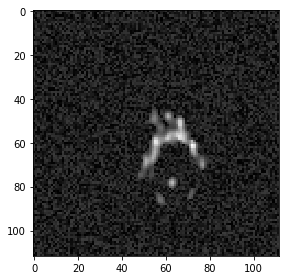

In [18]:
index_ = 10
print(list(mitosis_dict.keys())[np.argmax(y_train[index_])])
io.imshow(x_train[index_,0,:,:])

In [19]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1478, 1, 112, 112) (165, 1, 112, 112) (1478, 4) (165, 4)


In [20]:
import keras

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout, Reshape, Permute, Activation, \
    Input, merge, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import numpy as np
from scipy.misc import imread, imresize, imsave

from keras import backend as K
K.set_image_dim_ordering('th')

from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard
from customlayers import convolution2Dgroup, crosschannelnormalization, \
    splittensor, Softmax4D


def convnet(network, weights_path=None, heatmap=False,
            trainable=None):
    """
    Returns a keras model for a CNN.
    BEWARE !! : Since the different convnets have been trained in different settings, they don't take
    data of the same shape. You should change the arguments of preprocess_image_batch for each CNN :
    * For AlexNet, the data are of shape (227,227), and the colors in the RGB order (default)
    * For VGG16 and VGG19, the data are of shape (224,224), and the colors in the BGR order
    It can also be used to look at the hidden layers of the model.
    It can be used that way :
    >>> im = preprocess_image_batch(['cat.jpg'])
    >>> # Test pretrained model
    >>> model = convnet('vgg_16', 'weights/vgg16_weights.h5')
    >>> sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    >>> model.compile(optimizer=sgd, loss='categorical_crossentropy')
    >>> out = model.predict(im)
    Parameters
    --------------
    network: str
        The type of network chosen. For the moment, can be 'vgg_16' or 'vgg_19'
    weights_path: str
        Location of the pre-trained model. If not given, the model will be trained
    heatmap: bool
        Says wether the fully connected layers are transformed into Convolution2D layers,
        to produce a heatmap instead of a
    Returns
    ---------------
    model:
        The keras model for this convnet
    output_dict:
        Dict of feature layers, asked for in output_layers.
    """


    # Select the network
    if network == 'vgg_16':
        convnet_init = VGG_16
    elif network == 'vgg_19':
        convnet_init = VGG_19
    elif network == 'alexnet':
        convnet_init = AlexNet
    convnet = convnet_init(weights_path, heatmap=False)

    if not heatmap:
        return convnet
    else:
        convnet_heatmap = convnet_init(heatmap=True)

        for layer in convnet_heatmap.layers:
            if layer.name.startswith("conv"):
                orig_layer = convnet.get_layer(layer.name)
                layer.set_weights(orig_layer.get_weights())
            elif layer.name.startswith("dense"):
                orig_layer = convnet.get_layer(layer.name)
                W,b = orig_layer.get_weights()
                n_filter,previous_filter,ax1,ax2 = layer.get_weights()[0].shape
                new_W = W.reshape((previous_filter,ax1,ax2,n_filter))
                new_W = new_W.transpose((3,0,1,2))
                new_W = new_W[:,:,::-1,::-1]
                layer.set_weights([new_W,b])
        return convnet_heatmap

    return model




def VGG_16(weights_path=None, heatmap=False):
    model = Sequential()
    if heatmap:
        model.add(ZeroPadding2D((1,1),input_shape=(1,None,None)))
    else:
        model.add(ZeroPadding2D((1,1),input_shape=(1,112,112)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    if heatmap:
        model.add(Convolution2D(4096,7,7,activation="relu",name="dense_1"))
        model.add(Convolution2D(4096,1,1,activation="relu",name="dense_2"))
        model.add(Convolution2D(1000,1,1,name="dense_3"))
        model.add(Softmax4D(axis=1,name="softmax"))
    else:
        model.add(Flatten(name="flatten"))
        model.add(Dense(4096, activation='relu', name='dense_1'))
        model.add(Dropout(0.5))
        model.add(Dense(4096, activation='relu', name='dense_2'))
        model.add(Dropout(0.5))
        model.add(Dense(4, name='dense_3'))
        model.add(Activation("softmax",name="softmax"))

    if weights_path:
        model.load_weights(weights_path)
    return model




def VGG_19(weights_path=None,heatmap=False):
    model = Sequential()

    if heatmap:
        model.add(ZeroPadding2D((1,1),input_shape=(3,None,None)))
    else:
        model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_4'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_4'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_4'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    if heatmap:
        model.add(Convolution2D(4096,7,7,activation="relu",name="dense_1"))
        model.add(Convolution2D(4096,1,1,activation="relu",name="dense_2"))
        model.add(Convolution2D(1000,1,1,name="dense_3"))
        model.add(Softmax4D(axis=1,name="softmax"))
    else:
        model.add(Flatten())
        model.add(Dense(4096, activation='relu', name='dense_1'))
        model.add(Dropout(0.5))
        model.add(Dense(4096, activation='relu', name='dense_2'))
        model.add(Dropout(0.5))
        model.add(Dense(1000, name='dense_3'))
        model.add(Activation("softmax"))

    if weights_path:
        model.load_weights(weights_path)

    return model



def AlexNet(weights_path=None, heatmap=False):
    if heatmap:
        inputs = Input(shape=(3,None,None))
    else:
        inputs = Input(shape=(3,227,227))

    conv_1 = Convolution2D(96, 11, 11,subsample=(4,4),activation='relu',
                           name='conv_1')(inputs)

    conv_2 = MaxPooling2D((3, 3), strides=(2,2))(conv_1)
    conv_2 = crosschannelnormalization(name="convpool_1")(conv_2)
    conv_2 = ZeroPadding2D((2,2))(conv_2)
    conv_2 = merge([
        Convolution2D(128,5,5,activation="relu",name='conv_2_'+str(i+1))(
            splittensor(ratio_split=2,id_split=i)(conv_2)
        ) for i in range(2)], mode='concat',concat_axis=1,name="conv_2")

    conv_3 = MaxPooling2D((3, 3), strides=(2, 2))(conv_2)
    conv_3 = crosschannelnormalization()(conv_3)
    conv_3 = ZeroPadding2D((1,1))(conv_3)
    conv_3 = Convolution2D(384,3,3,activation='relu',name='conv_3')(conv_3)

    conv_4 = ZeroPadding2D((1,1))(conv_3)
    conv_4 = merge([
        Convolution2D(192,3,3,activation="relu",name='conv_4_'+str(i+1))(
            splittensor(ratio_split=2,id_split=i)(conv_4)
        ) for i in range(2)], mode='concat',concat_axis=1,name="conv_4")

    conv_5 = ZeroPadding2D((1,1))(conv_4)
    conv_5 = merge([
        Convolution2D(128,3,3,activation="relu",name='conv_5_'+str(i+1))(
            splittensor(ratio_split=2,id_split=i)(conv_5)
        ) for i in range(2)], mode='concat',concat_axis=1,name="conv_5")

    dense_1 = MaxPooling2D((3, 3), strides=(2,2),name="convpool_5")(conv_5)

    if heatmap:
        dense_1 = Convolution2D(4096,6,6,activation="relu",name="dense_1")(dense_1)
        dense_2 = Convolution2D(4096,1,1,activation="relu",name="dense_2")(dense_1)
        dense_3 = Convolution2D(1000, 1,1,name="dense_3")(dense_2)
        prediction = Softmax4D(axis=1,name="softmax")(dense_3)
    else:
        dense_1 = Flatten(name="flatten")(dense_1)
        dense_1 = Dense(4096, activation='relu',name='dense_1')(dense_1)
        dense_2 = Dropout(0.5)(dense_1)
        dense_2 = Dense(4096, activation='relu',name='dense_2')(dense_2)
        dense_3 = Dropout(0.5)(dense_2)
        dense_3 = Dense(4,name='dense_3')(dense_3)
        prediction = Activation("softmax",name="softmax")(dense_3)


    model = Model(input=inputs, output=prediction)

    if weights_path:
        model.load_weights(weights_path, exclude=["dense_3", "softmax"])

    return model







# Test pretrained model
model = convnet('vgg_16', heatmap=False)
#model.load_weights('/media/lsdf02/sd17a005/LSDF2_Bjoern/For_Lukas/weights/vgg_16-weights-eight-phenotypes-24-0.81.hdf5')
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False),
              metrics=['accuracy'])

filepath="/mnt/isilon/Group/Lukas/weights/vgg_16-weights-four-phenotypes-compare-random-forest-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16)
callbacks = [checkpoint, tensorboard]

/home/titanv/miniconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:91: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_1")`
/home/titanv/miniconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:93: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_2")`
/home/titanv/miniconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_1")`
/home/titanv/miniconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:99: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_2")`
/home/titanv/miniconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:103: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", name="co

In [27]:
from keras.models import load_model

#/mnt/isilon/Group/Lukas/weights/vgg_16-weights-nine-phenotypes-10-0.93.hdf5
model = load_model('/mnt/isilon/Group/Lukas/weights/vgg_16-weights-four-phenotypes-compare-random-forest-27-0.78.hdf5')

In [28]:
print(model.layers[0].output)

Tensor("zero_padding2d_1_2/Pad:0", shape=(?, 1, 114, 114), dtype=float32)


In [22]:
batch_size = 16
epochs = 50


history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test),
              callbacks=callbacks
             )
sess.close()

Train on 1478 samples, validate on 165 samples
Epoch 1/50
1478/1478 [==============================] - 8s 5ms/step - loss: 1.2277 - acc: 0.4445 - val_loss: 1.2543 - val_acc: 0.3939

Epoch 00001: val_acc improved from -inf to 0.39394, saving model to /mnt/isilon/Group/Lukas/weights/vgg_16-weights-four-phenotypes-compare-random-forest-01-0.39.hdf5
Epoch 2/50
1478/1478 [==============================] - 5s 4ms/step - loss: 1.0125 - acc: 0.5589 - val_loss: 1.1092 - val_acc: 0.5394

Epoch 00002: val_acc improved from 0.39394 to 0.53939, saving model to /mnt/isilon/Group/Lukas/weights/vgg_16-weights-four-phenotypes-compare-random-forest-02-0.54.hdf5
Epoch 3/50
1478/1478 [==============================] - 5s 4ms/step - loss: 0.9412 - acc: 0.5792 - val_loss: 1.0151 - val_acc: 0.5576

Epoch 00003: val_acc improved from 0.53939 to 0.55758, saving model to /mnt/isilon/Group/Lukas/weights/vgg_16-weights-four-phenotypes-compare-random-forest-03-0.56.hdf5
Epoch 4/50
1478/1478 [======================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


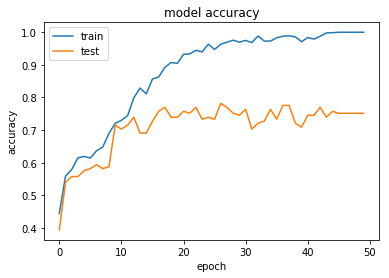

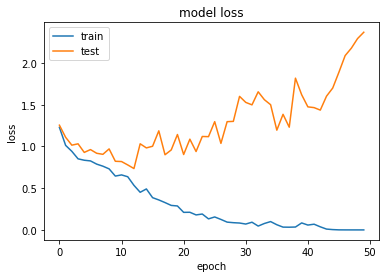

In [23]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
model.evaluate(x=x_test, y=y_test, batch_size=16, verbose=1)

165/165 [==============================] - 1s 3ms/step


[1.0364492011792732, 0.7818181821794221]

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
print(x_test.shape)

(165, 1, 112, 112)


In [32]:
predict_test = model.predict([x_test])

In [33]:
print(predict_test.shape)

(165, 4)


In [34]:
cnf_matrix = confusion_matrix(np.argmax(predict_test, axis=1), np.argmax(y_test, axis=1))

In [35]:
import csv

In [36]:
with open("/mnt/isilon/Group/Lukas/bjoern_paper/cnf_matrix_four_phenotypes_comparison_random_forest.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(cnf_matrix)

In [37]:
import itertools

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.89285714 0.         0.01785714 0.08928571]
 [0.06122449 0.65306122 0.10204082 0.18367347]
 [0.         0.1        0.9        0.        ]
 [0.15       0.25       0.05       0.55      ]]


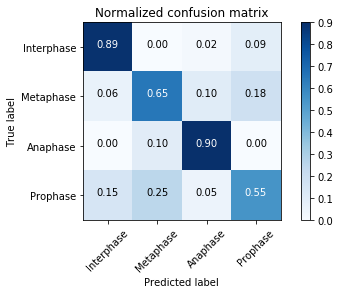

In [39]:
# Plot non-normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=['Interphase', 'Metaphase', 'Anaphase', 'Prophase'],
                      #title='Confusion matrix without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(mitosis_dict.keys()), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [38]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [39]:
#For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        predict_test[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], predict_test[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    predict_test.ravel())
average_precision["micro"] = average_precision_score(y_test, predict_test,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))


Average precision score, micro-averaged over all classes: 0.98


Text(0.5,1,'Average precision score, micro-averaged over all classes: AP=0.98')

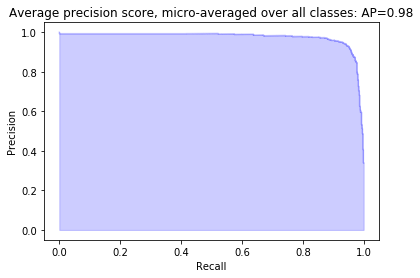

In [40]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

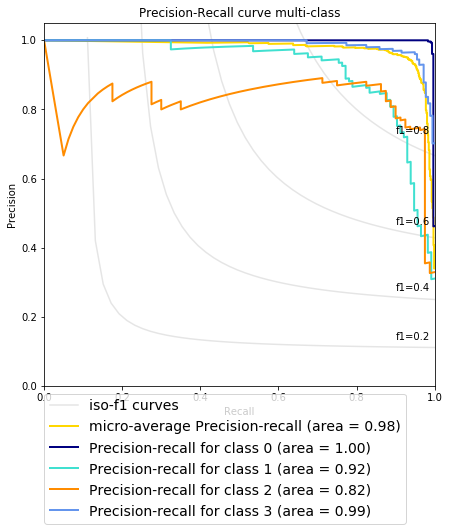

In [42]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(4), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()